# Capstone Project: The Battle of Neighborhoods

# Analysis of San Francisco Neighborhoods

## Table of Contents

[1. Introduction](#item1)

[2. Data](#item2)

[3. Methodology](#item3)

[4. Results & Discussion](#item4)

[5. Conclusion](#item5)

## 1. Introduction <a name="item1"></a>

### 1.1 Background

San Francisco is one of the United States' most well known cities. It is the cultural, commercial, and financial center of Northern California and is famous for its iconic Golden Gate Bridge and cable cars. As a popular tourist destination and the headquarters for numerous major international companies and banks, the city is an important global center that attracts people from far and wide to make a living there. 

Before making the move to start a business, it is important to familiarize oneself with the areas and neighborhoods of a city as diverse as San Francisco. Prospective business owners must first understand the best location where their business will be successful. The neighborhood a small business is in will most certainly impact the number of customers it will have. In terms of location, three of the most important factors that will influence the success of a business are: 
1. Finding the location that is best suited for the business's intended target market.
2. Understanding the location's area traffic.
3. Finding a location that provides easy accessibility and visibility.

Of course, there are various other important factors to consider, such as the cost of rent or the crime index of a location. However, this report will focus on the three factors that were listed above to provide some preliminary insight on where one should start a new business in San Francisco. It should also be noted that although this study is focused on the city of San Francisco, the same ideas and approach can be applied to other cities as well.

### 1.2 Business Problem: Where should JB open an Indian-Italian fusion cuisine restaurant in San Francisco? 

A college friend of mine, JB, expressed interest in opening a new Indian-Italian fusion cuisine restaurant in San Francisco. She is drawn to the city by its lively multicultural atmosphere and wishes to contribute to this melting pot. However, since there are so many neighborhoods in San Francisco, each with their own distinct area traffic and demographics of people, she is puzzled by where to start looking first. As such, JB is interested in learning more about each neighborhood and has stated several facts about her intended restaurant to help with the analysis. Her restaurant:
- Should appeal to everyone (locals and tourists alike).
- Is unique and stands out.
- Will primarily serve lunch and dinner.
- Will be moderately priced (~$$$).

This report will use data science methods to identify the most promising neighborhoods for JB to start exploring for her new restaurant. The study will consider JB's intended market criteria based on the three location factors as listed in the *Background* section.

## 2. Data <a name="item2"></a>

This section will provide a description of the data and how it will be used to solve the stated business problem.

### 2.1 Description of the Data

The following data was used to study the neighborhoods of San Francisco:

1. **San Francisco GeoJSON**: Contains the neighborhoods that exist in San Francisco as well as their respective latitude and longitude coordinates. This data was sourced from: https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4.
2. **Venues in San Francisco**: A collection of all the venues in San Francisco, named *venues_df*. The dataset was pulled using the **Foursquare** API and includes each venue's name, what neighborhood they're in, their respective latitude and longitude coordinates, and their respective venue category.

### 2.2 How the Data Will Be Used to Solve the Business Problem

Exploratory data analysis will be performed to understand the two datasets in order to solve the business problem.

The San Francisco GeoJSON data will be used to show the neighborhood shapes. Each neighborhood's "coordinates" of the geometry object is composed of a multipolygon which is a multidimensional array of positions. Modifications were performed on the GeoJSON data to transform it into a polygon format that is easier to use for further analysis. This step was done before loading the data into this notebook.

The Venues in San Francisco data will be used for finding all of the commerce venues associated with each neighborhood. As we are trying to understand each neighborhood's area traffic and potential to be a suitable market location that satisfies JB's criterias, the commerce venues information is used to get an impression of the kinds of people that frequent each neighborhood.

In the analysis, folium will be used to visualize San Francisco and the locations of each venue of interest. One hot encoding will be used to divide the commerce venues into: Business Offices, Colleges, Hotels, Public Areas, Restaurants, Shopping Areas, and Social Places. This subdivision will allow us to analyze what commerce types each neighborhood is known for so we can better determine the one that is best suited for JB's restaurant. Finally, K-means clustering will be used on the venues dataset to see what venue categories can be used to distinguish each neighborhood cluster.

## 3. Methodology <a name="item3"></a>

This section represents the main component of the report where I will detail the exploratory data analysis that was done, the inferential statistical testing that was performed, and the k-means clustering machine learning that was used.

### 3.1 Python Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics

from scipy.spatial.distance import cdist

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### 3.2 Data Preparation - San Francisco GeoJSON

Load the San Francisco GeoJSON data which includes each neighborhood's name and their respective latitudes and longitudes.

In [2]:
# Open JSON file 
f = open('SF.geojson',) 
  
# Return JSON object as a dictionary 
f_data = json.load(f)
#f_data

Notice that all of the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data and then look at the first item in this list.

In [3]:
sf_data = f_data['features']
sf_data[0]

{'type': 'Feature',
 'properties': {'link': 'http://en.wikipedia.org/wiki/Sea_Cliff,_San_Francisco,_California',
  'name': 'Seacliff'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-122.49345526799993, 37.78351817100008],
    [-122.49372649999992, 37.78724665100009],
    [-122.49358666699993, 37.78731259500006],
    [-122.49360569399994, 37.78752774600008],
    [-122.49283007399993, 37.787882585000034],
    [-122.4927566799999, 37.78773917700005],
    [-122.48982906399993, 37.789482184000065],
    [-122.48899105699991, 37.78928318700008],
    [-122.4878640209999, 37.78958817900008],
    [-122.48736904899994, 37.78942984100007],
    [-122.48598032899991, 37.79080370600008],
    [-122.48581537399991, 37.79070384600004],
    [-122.48557750799989, 37.790559847000054],
    [-122.4850531269999, 37.79036813300007],
    [-122.4842660519999, 37.789411709000035],
    [-122.48407706799992, 37.78939909400009],
    [-122.4838230019999, 37.78928250300004],
    [-122.48370738599994, 37.788776

Tranform this data of nested Python dictionaries into a _pandas_ dataframe.

In [4]:
# Define the dataframe columns
column_names = ['Neighborhood','Geometry']

# Instantiate the dataframe
neighborhoods_data = pd.DataFrame(columns=column_names)

for data in sf_data:
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    
    neighborhoods_data = neighborhoods_data.append({'Neighborhood': neighborhood_name,
                                                    'Geometry': neighborhood_latlon}, ignore_index=True)

neighborhoods_data.head()

Neighborhood                                           Geometry
0                Seacliff  [[[-122.49345526799993, 37.78351817100008], [-...
1             Lake Street  [[[-122.48715071499993, 37.783785427000055], [...
2  Presidio National Park  [[[-122.47758017099994, 37.81099311300005], [-...
3        Presidio Terrace  [[[-122.47241052999993, 37.787346539000055], [...
4          Inner Richmond  [[[-122.47262578999994, 37.786314806000064], [...

Let's see how many neighborhoods are in San Francisco.

In [5]:
print("The dataframe has {} neighborhoods.".format(len(neighborhoods_data['Neighborhood'].unique())))

The dataframe has 117 neighborhoods.


From each neighborhood's geometry, let's calculate their respective centroid coordinates.

In [6]:
neighborhoods_data['Centroid'] = neighborhoods_data['Geometry'].apply(lambda inp: [[sum(m)/float(len(m)) for m in zip(*l)] for l in inp])
neighborhoods_data['Centroid'] = neighborhoods_data['Centroid'].apply(np.ravel) # flatten the nested list into one single list
neighborhoods_data['Centroid'] = neighborhoods_data['Centroid'].apply(tuple) # convert list to tuple

In [7]:
# Separate the centroid tuples into latitude and longitude columns
neighborhoods_data[['Longitude', 'Latitude']] = pd.DataFrame(neighborhoods_data['Centroid'].tolist(), index=neighborhoods_data.index)

Quickly examine the resulting dataframe.


In [8]:
neighborhoods_data.head()

Neighborhood                                           Geometry  \
0                Seacliff  [[[-122.49345526799993, 37.78351817100008], [-...   
1             Lake Street  [[[-122.48715071499993, 37.783785427000055], [...   
2  Presidio National Park  [[[-122.47758017099994, 37.81099311300005], [-...   
3        Presidio Terrace  [[[-122.47241052999993, 37.787346539000055], [...   
4          Inner Richmond  [[[-122.47262578999994, 37.786314806000064], [...   

                                   Centroid   Longitude   Latitude  
0  (-122.48727411196657, 37.78794365720007) -122.487274  37.787944  
1  (-122.48056858607683, 37.78615137738468) -122.480569  37.786151  
2  (-122.46797365011281, 37.79926798262909) -122.467974  37.799268  
3  (-122.46795748666659, 37.78692981188894) -122.467957  37.786930  
4   (-122.46875409127264, 37.7811122254546) -122.468754  37.781112

In [9]:
neighborhoods_data.dtypes

Neighborhood     object
Geometry         object
Centroid         object
Longitude       float64
Latitude        float64
dtype: object

### 3.3 Data Collection - Coordinates of San Francisco

#### Use geopy library to get the latitude and longitude values of San Francisco.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>sf_explorer</em>.


In [10]:
address = 'San Francisco, CA'

geolocator = Nominatim(user_agent="sf_explorer")
location = geolocator.geocode(address, timeout=None)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7790262, -122.4199061.


Create a map of San Francisco with the neighborhood centroids superimposed on top.

In [11]:
# Create map of San Francisco using latitude and longitude values
map_sanfrancisco = folium.Map(location=[latitude, longitude], zoom_start=12)

# Add markers to map
for lat, lng, neighborhood in zip(neighborhoods_data['Latitude'], neighborhoods_data['Longitude'], neighborhoods_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_sanfrancisco)  
    
map_sanfrancisco

Feel free to zoom into the above map, and click on each circle marker to reveal the name of the neighborhood.

Next, we are going to start utilizing the **Foursquare** API to explore the neighborhoods and segment them.

### 3.4 Data Collection - Venues in San Francisco

#### Use Foursquare API to get the venues

Define Foursquare credentials and version.

In [12]:
CLIENT_ID = '...'
CLIENT_SECRET = '...'
VERSION = '20190605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Create the functions that will extract the data from Foursquare.

In [13]:
# Function that extracts the venue
def get_Venues(neighborhood, latitude, longitude, category=None, radius=1000):
    
    venues_list = []
    params = {'client_id': CLIENT_ID,
              'client_secret': CLIENT_SECRET,
              'v': VERSION,
              'll': '{},{}'.format(latitude, longitude),
              'radius': radius,
              'limit': LIMIT}
    url = 'https://api.foursquare.com/v2/venues/search'
    results = requests.get(url, params=params).json()
    
    if not results['response']:
        return []

    for v in results['response']['venues']:
        if not v['categories']:
            continue
        venues_list.append([neighborhood,
                            latitude, 
                            longitude, 
                            v['name'], 
                            v['location']['lat'], 
                            v['location']['lng'],
                            v['categories'][0]["name"]])
    return venues_list

In [14]:
def get_NearbyVenues(neighborhoods, latitudes, longitudes, category=None, radius=1000):
    
    venues_list = []
    for neig, lat, lng in zip(neighborhoods, latitudes, longitudes):
        results = get_Venues(neig, lat, lng, category=category, radius=radius)
        venues_list += results
        
    if not venues_list:
        print("venue list is empty")
        return []
    
    venues_data = pd.DataFrame(venue for venue in venues_list)
    venues_data.columns = ['Neighborhood', 
                           'Neighborhood Latitude', 
                           'Neighborhood Longitude', 
                           'Venue', 
                           'Venue Latitude', 
                           'Venue Longitude',
                           'Venue Category',]
    
    return venues_data

Now pull each neighborhood's data into a dataframe called *venues_df*. This will become our **Venues in San Francisco** data.

In [15]:
venues_df = get_NearbyVenues(neighborhoods=neighborhoods_data['Neighborhood'],
                            latitudes=neighborhoods_data['Latitude'],
                            longitudes=neighborhoods_data['Longitude'])
venues_df.head(10)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Seacliff              37.787944             -122.487274   
1     Seacliff              37.787944             -122.487274   
2     Seacliff              37.787944             -122.487274   
3     Seacliff              37.787944             -122.487274   
4     Seacliff              37.787944             -122.487274   
5     Seacliff              37.787944             -122.487274   
6     Seacliff              37.787944             -122.487274   
7     Seacliff              37.787944             -122.487274   
8     Seacliff              37.787944             -122.487274   
9     Seacliff              37.787944             -122.487274   

                     Venue  Venue Latitude  Venue Longitude  \
0              Baker Beach       37.793355      -122.483740   
1              China Beach       37.788090      -122.491186   
2  Lands End Coastal Trail       37.784183      -122.509022   
3         UC San Francisco       37.789087      -122.487971   
4      Lincoln Park Stairs       37.783496      -122.493597   
5             Pizzetta 211       37.783694      -122.482879   
6  El Camino del Mar Trail       37.786568      -122.494399   
7               Muni 13838       37.783792      -122.485390   
8     MUNI Bus Stop #13839       37.783956      -122.484822   
9              Lobos Creek       37.786981      -122.485191   

                    Venue Category  
0                            Beach  
1                            Beach  
2                            Trail  
3  College Administrative Building  
4                            Trail  
5                      Pizza Place  
6                            Trail  
7                      Bus Station  
8                         Bus Stop  
9             Other Great Outdoors

### 3.5 Exploratory Data Analysis

#### 3.5.1 Get the Relevant Venues

Check how many venues were returned for each neighborhood.

In [16]:
venues_df.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                                  
Alamo Square                                     64                      64   
Anza Vista                                       96                      96   
Apparel City                                     90                      90   
Aquatic Park / Ft. Mason                         99                      99   
Ashbury Heights                                  78                      78   
Balboa Terrace                                   92                      92   
Bayview                                          94                      94   
Bernal Heights                                   87                      87   
Bret Harte                                       70                      70   
Buena Vista                                      71                      71   
Candlestick Point SRA                            89                      89   
Castro                                           85                      85   
Cathedral Hill                                   63                      63   
Cayuga                                           86                      86   
Central Waterfront                               86                      86   
Chinatown                                        95                      95   
Civic Center                                     88                      88   
Clarendon Heights                                89                      89   
Cole Valley                                      75                      75   
Corona Heights                                   78                      78   
Cow Hollow                                       83                      83   
Crocker Amazon                                   76                      76   
Diamond Heights                                  94                      94   
Dogpatch                                         89                      89   
Dolores Heights                                  51                      51   
Downtown / Union Square                          92                      92   
Duboce Triangle                                  80                      80   
Eureka Valley                                    70                      70   
Excelsior                                        90                      90   
Fairmount                                        63                      63   
Financial District                               92                      92   
Fishermans Wharf                                 97                      97   
Forest Hill                                      85                      85   
Forest Knolls                                    77                      77   
Glen Park                                        87                      87   
Golden Gate Heights                              80                      80   
Golden Gate Park                                 93                      93   
Haight Ashbury                                   85                      85   
Hayes Valley                                     77                      77   
Holly Park                                       85                      85   
Hunters Point                                    91                      91   
India Basin                                      90                      90   
Ingleside                                        87                      87   
Ingleside Terraces                               92                      92   
Inner Richmond                                   85                      85   
Inner Sunset                                     93                      93   
Japantown                                        90                      90   
Laguna Honda                                     90                      90   
Lake Street                                      87                      87   
L

Check how many unique categories can be curated from all the returned venues.


In [17]:
print('There are {} uniques categories.'.format(len(venues_df['Venue Category'].unique())))

There are 529 uniques categories.


Now that we know there are 529 unique venue categories, let's only use those that are relevant to satisfying the 3 location factors as stated in the *Background* section. 

To begin, we refer back to JB's criterias list for her restaurant. She stated that her restaurant would cater to both locals and tourists. From this valuable information, we can narrow down our venues category list to those venues that are frequented by both locals and tourists alike. First, we know that tourists must reside inside hotels, motels, or resorts so let's group all of those venues together into a *Hotels* category. Next, we know that both locals and tourists love to eat at restaurants, shop, mingle in social places like bars, clubs, and other nightlife venues, and visit public spaces like parks, beaches, or San Francisco's piers. Therefore, we will find all of the venues that fall within the *Restaurants*, *Shopping Areas*, *Social Places*, and *Public Areas* categories. But now, what are the specific venues that only locals usually frequent? Of course, locals would go to any venue within their hometown but we know that office buildings and other business places are most usually frequented by locals who work in the city. We also can't forget about the university students who go to school and live inside the city. As such, we will include all venues that are related to both of those into *Business Offices* and *Colleges*. 

Great, now that we have a list of these "commerce venues", let's create a dataframe called *commerce_venues_df* that contains all of the venues we just determined which will be useful in our analysis.

In [18]:
# Define a dataframe that contains all of the venues of interest as described above.
commerce_venues_df = venues_df[(venues_df['Venue Category'].str.contains('Bakery')==True) |
                               (venues_df['Venue Category'].str.contains('Bar')==True) |
                               (venues_df['Venue Category'].str.contains('Beach')==True) |
                               (venues_df['Venue Category'].str.contains('Bistro')==True) |
                               (venues_df['Venue Category'].str.contains('Breakfast')==True) |
                               (venues_df['Venue Category'].str.contains('Burger Joint')==True) |
                               (venues_df['Venue Category'].str.contains('Burrito Place')==True) |
                               (venues_df['Venue Category'].str.contains('Business')==True) |
                               (venues_df['Venue Category'].str.contains('Café')==True) |
                               (venues_df['Venue Category'].str.contains('College')==True) |
                               (venues_df['Venue Category'].str.contains('Creperie')==True) |
                               (venues_df['Venue Category'].str.contains('Diner')==True) |
                               (venues_df['Venue Category'].str.contains('Food')==True) |
                               (venues_df['Venue Category'].str.contains('Fried Chicken Joint')==True) |
                               (venues_df['Venue Category'].str.contains('Gastropub')==True) |
                               (venues_df['Venue Category'].str.contains('Harbor / Marina')==True) |
                               (venues_df['Venue Category'].str.contains('Hotel')==True) |
                               (venues_df['Venue Category'].str.contains('Mac & Cheese Joint')==True) |
                               (venues_df['Venue Category'].str.contains('Market')==True) |
                               (venues_df['Venue Category'].str.contains('Motel')==True) |
                               (venues_df['Venue Category'].str.contains('Nightclub')==True) |
                               (venues_df['Venue Category'].str.contains('Nightlife Spot')==True) |
                               (venues_df['Venue Category'].str.contains('Noodle House')==True) |
                               (venues_df['Venue Category'].str.contains('Office')==True) |
                               (venues_df['Venue Category'].str.contains('Park')==True) |
                               (venues_df['Venue Category'].str.contains('Parking')==True) |
                               (venues_df['Venue Category'].str.contains('Pier')==True) |
                               (venues_df['Venue Category'].str.contains('Pizza Place')==True) |
                               (venues_df['Venue Category'].str.contains('Plaza')==True) |
                               (venues_df['Venue Category'].str.contains('Pub')==True) |
                               (venues_df['Venue Category'].str.contains('Resort')==True) |
                               (venues_df['Venue Category'].str.contains('Restaurant')==True) |
                               (venues_df['Venue Category'].str.contains('Salad Place')==True) |
                               (venues_df['Venue Category'].str.contains('Sandwich Place')==True) |
                               (venues_df['Venue Category'].str.contains('Shop')==True) |
                               (venues_df['Venue Category'].str.contains('Shopping Mall')==True) |
                               (venues_df['Venue Category'].str.contains('Steakhouse')==True) |
                               (venues_df['Venue Category'].str.contains('Store')==True) |
                               (venues_df['Venue Category'].str.contains('Supermarket')==True) |
                               (venues_df['Venue Category'].str.contains('Taco Place')==True)].reset_index(drop=True)

We've isolated data that satisfies one of JB's criterias where she wants to serve both locals and tourists. Next, let's move on to meeting her second requirement, the one where she wants her restaurant to be unique and stand out among other restaurants in the area. The first logical step is to take a look at all of the different restaurants and eateries that are in San Francisco. Then, because we know JB's restaurant will serve Indian-Italian fusion cuisine, we will study where each Indian and Italian restaurant in the city is located and eventually try to pick a neighborhood that does not have one of those restaurant types to maximize her restaurant's uniqueness in the area.

In [19]:
# Define a dataframe that just contains the restaurants and foodservice venues
restaurants_df = commerce_venues_df[(commerce_venues_df['Venue Category'].str.contains('Restaurant')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Bagel Shop')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Bistro')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Breakfast')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Burger Joint')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Burrito Place')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Café')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Creperie')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Dessert Shop')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Diner')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Food')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Fried Chicken Joint')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Gastropub')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Mac & Cheese Joint')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Noodle House')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Pizza Place')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Pub')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Salad Place')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Sandwich Place')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Sandwich Shop')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Steakhouse')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Souvlaki Shop')==True) |
                                    (commerce_venues_df['Venue Category'].str.contains('Taco Place')==True)].reset_index(drop=True)
restaurants_df.head(10)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Seacliff              37.787944             -122.487274   
1     Seacliff              37.787944             -122.487274   
2     Seacliff              37.787944             -122.487274   
3     Seacliff              37.787944             -122.487274   
4     Seacliff              37.787944             -122.487274   
5  Lake Street              37.786151             -122.480569   
6  Lake Street              37.786151             -122.480569   
7  Lake Street              37.786151             -122.480569   
8  Lake Street              37.786151             -122.480569   
9  Lake Street              37.786151             -122.480569   

                      Venue  Venue Latitude  Venue Longitude  \
0              Pizzetta 211       37.783694      -122.482879   
1           Angelina's Cafe       37.784074      -122.481809   
2          Little Sushi Bar       37.783873      -122.482761   
3  Ocean Side Mexican Grill       37.784411      -122.480892   
4                     Pearl       37.783839      -122.483083   
5                     Pearl       37.783839      -122.483083   
6               Bazaar Cafe       37.784050      -122.481320   
7           Angelina's Cafe       37.784074      -122.481809   
8              Bread N’ Chu       37.782377      -122.479714   
9                      Home       37.782244      -122.480962   

       Venue Category  
0         Pizza Place  
1                Café  
2    Sushi Restaurant  
3  Mexican Restaurant  
4          Restaurant  
5          Restaurant  
6                Café  
7                Café  
8      Sandwich Place  
9                Café

In [20]:
# Define dataframes that just contain Indian and Italian restaurants
indian_restaurants_df = restaurants_df[restaurants_df['Venue Category'] == 'Indian Restaurant']
italian_restaurants_df = restaurants_df[restaurants_df['Venue Category'].isin(['Italian Restaurant', 'Pizza Place'])]

# All other restaurants and foodservice venues
other_restaurants_df = restaurants_df[(restaurants_df['Venue Category'] != 'Indian Restaurant') & (restaurants_df['Venue Category'] != 'Italian Restaurant') & (restaurants_df['Venue Category'] != 'Pizza Place')]

The distribution of Indian and Italian restaurants within San Francisco will now be visualized. The color code is set as follows: 

Restaurant | Color      
---|--------------------
Indian    |	green   
Italian   |	orange   
Other     |	gray   

In [21]:
# Create map of San Francisco using latitude and longitude values
map_sanfrancisco = folium.Map(location=[latitude, longitude], zoom_start=12)
restaurants = folium.map.FeatureGroup()

# Add markers to map
for lat, lng, venue, neigh in zip(other_restaurants_df['Venue Latitude'], other_restaurants_df['Venue Longitude'], other_restaurants_df['Venue'], other_restaurants_df['Neighborhood']):
    label = 'Name: {}, Neighborhood: {}'.format(venue, neigh)
    label = folium.Popup(label, parse_html=True)
    restaurants.add_child(folium.CircleMarker([lat, lng],
                                              radius=2,
                                              popup=label,
                                              color='gray',
                                              fill=True,
                                              fill_color='#c0c0c0',
                                              fill_opacity=0.7,)
                         )
for lat, lng, venue, neigh in zip(italian_restaurants_df['Venue Latitude'], italian_restaurants_df['Venue Longitude'], italian_restaurants_df['Venue'], italian_restaurants_df['Neighborhood']):
    label = 'Name: {}, Neighborhood: {}'.format(venue, neigh)
    label = folium.Popup(label, parse_html=True)
    restaurants.add_child(folium.CircleMarker([lat, lng],
                                              radius=3,
                                              popup=label,
                                              color='orange',
                                              fill=True,
                                              fill_color='#cc9831',
                                              fill_opacity=0.7,)
                         )
for lat, lng, venue, neigh in zip(indian_restaurants_df['Venue Latitude'], indian_restaurants_df['Venue Longitude'], indian_restaurants_df['Venue'], indian_restaurants_df['Neighborhood']):
    label = 'Name: {}, Neighborhood: {}'.format(venue, neigh)
    label = folium.Popup(label, parse_html=True)
    restaurants.add_child(folium.CircleMarker([lat, lng],
                                              radius=3,
                                              popup=label,
                                              color='green',
                                              fill=True,
                                              fill_color='#31cc5a',
                                              fill_opacity=0.7,)
                         )
map_sanfrancisco.add_child(restaurants)
map_sanfrancisco

From the map of San Francisco above, we can see where each Indian and Italian restaurant is located. Please click on the markers to view the name of the restaurant and the neighborhood that it is in.

#### 3.5.2 Analyze Each Neighborhood

We will now analyze each neighborhood to get a better understanding of them and finally prepare a list of most suitable neighborhoods for JB to start looking into.

Apply one hot encoding to the list of venue categories such that a new binary variable is added for each unique venue category per row.

In [22]:
# One hot encoding
sf_onehot = pd.get_dummies(commerce_venues_df[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = commerce_venues_df['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

sf_onehot.head()

Neighborhood  Accessories Store  African Restaurant  American Restaurant  \
0     Seacliff                  0                   0                    0   
1     Seacliff                  0                   0                    0   
2     Seacliff                  0                   0                    0   
3     Seacliff                  0                   0                    0   
4     Seacliff                  0                   0                    0   

   Antique Shop  Argentinian Restaurant  Arts & Crafts Store  \
0             0                       0                    0   
1             0                       0                    0   
2             0                       0                    0   
3             0                       0                    0   
4             0                       0                    0   

   Asian Restaurant  Automotive Shop  Baby Store  Bagel Shop  Bakery  Bar  \
0                 0                0           0           0       0    0   
1                 0                0           0           0       0    0   
2                 0                0           0           0       0    0   
3                 0                0           0           0       0    0   
4                 0                0           0           0       0    0   

   Beach  Bed & Breakfast  Beer Bar  Big Box Store  Bike Shop  Bistro  \
0      1                0         0              0          0       0   
1      1                0         0              0          0       0   
2      0                0         0              0          0       0   
3      0                0         0              0          0       0   
4      0                0         0              0          0       0   

   Board Shop  Brazilian Restaurant  Breakfast Spot  Bridal Shop  \
0           0                     0               0            0   
1           0                     0               0            0   
2           0                     0               0            0   
3           0                     0               0            0   
4           0                     0               0            0   

   Bubble Tea Shop  Burger Joint  Burmese Restaurant  Burrito Place  \
0                0             0                   0              0   
1                0             0                   0              0   
2                0             0                   0              0   
3                0             0                   0              0   
4                0             0                   0              0   

   Business Center  Business Service  Café  Cajun / Creole Restaurant  \
0                0                 0     0                          0   
1                0                 0     0                          0   
2                0                 0     0                          0   
3                0                 0     0                          0   
4                0                 0     1                          0   

   Camera Store  Campaign Office  Candy Store  Cantonese Restaurant  \
0             0                0            0                     0   
1             0                0            0                     0   
2             0                0            0                     0   
3             0                0            0                     0   
4             0                0            0                     0   

   Caribbean Restaurant  Carpet Store  Cheese Shop  Chinese Restaurant  \
0                     0             0            0                   0   
1                     0             0            0                   0   
2                     0             0            0                   0   
3                     0             0            0                   0   
4                     0             0            0                   0   

   Chocolate Shop  Clothing Store  Cocktail Bar  Coffee Shop  \
0               0               0  

Examine the new dataframe size.


In [23]:
sf_onehot.shape

(4076, 246)

Next, group rows by neighborhood and count the frequency of occurrence of each category.

In [24]:
sf_grouped = sf_onehot.groupby('Neighborhood').sum().reset_index()
sf_grouped.head()

Neighborhood  Accessories Store  African Restaurant  \
0              Alamo Square                  0                   0   
1                Anza Vista                  0                   0   
2              Apparel City                  0                   0   
3  Aquatic Park / Ft. Mason                  0                   0   
4           Ashbury Heights                  0                   0   

   American Restaurant  Antique Shop  Argentinian Restaurant  \
0                    0             1                       0   
1                    0             0                       0   
2                    1             1                       0   
3                    0             0                       0   
4                    0             1                       0   

   Arts & Crafts Store  Asian Restaurant  Automotive Shop  Baby Store  \
0                    0                 0                0           0   
1                    0                 0                0           0   
2                    1                 0               10           0   
3                    4                 0                0           0   
4                    0                 0                0           0   

   Bagel Shop  Bakery  Bar  Beach  Bed & Breakfast  Beer Bar  Big Box Store  \
0           0       0    0      0                0         0              0   
1           0       0    0      0                0         0              1   
2           0       0    0      0                0         0              0   
3           0       0    0      2                0         0              0   
4           0       1    0      0                1         0              0   

   Bike Shop  Bistro  Board Shop  Brazilian Restaurant  Breakfast Spot  \
0          0       0           0                     0               0   
1          0       0           0                     0               1   
2          0       0           0                     0               0   
3          0       0           0                     0               0   
4          0       0           0                     0               0   

   Bridal Shop  Bubble Tea Shop  Burger Joint  Burmese Restaurant  \
0            0                0             0                   0   
1            0                0             1                   0   
2            0                0             0                   0   
3            0                0             0                   0   
4            0                0             0                   0   

   Burrito Place  Business Center  Business Service  Café  \
0              0                0                 0     0   
1              0                0                 1     1   
2              0                0                 0     1   
3              0                0                 0     2   
4              0                0                 0     0   

   Cajun / Creole Restaurant  Camera Store  Campaign Office  Candy Store  \
0                          0             0                0            0   
1                          0             0                0            0   
2                          0             0                0            0   
3                          0             0                0            0   
4                          0             0                0            0   

   Cantonese Restaurant  Caribbean Restaurant  Carpet Store  Cheese Shop  \
0                     0                     0             0            0   
1                     0                     0             0            0   
2                     0                     0             0            0   
3                     0                     0             0            0   
4                     0                     0             0            0   

   Chinese Restaurant  Chocolate Shop  Clothing Store  Cocktail Bar  \
0                   0               0               1             0   
1           

Confirm the new size.


In [25]:
sf_grouped.shape

(117, 246)

Now, let's sort each venue into their overarching commerce venue group and count the number of each group by neighborhood. These groups include: Business Offices, Colleges, Hotels, Public Areas, Restaurants, Shopping Areas, and Social Places.

In [26]:
# Create a reference dataframe that contains the same indexing as sf_grouped
sf_grouped_sum = pd.DataFrame()
sf_grouped_sum = sf_grouped.iloc[:, :1]

# Create a separate dataframe for each category containing the sum of the specific category
col_businessOffices = [i for i in sf_grouped.columns if 'Business' in i or 'Office' in i]
businessOffices = sf_grouped[col_businessOffices].sum(axis = 1).reset_index(name='Business Offices')
businessOffices.set_index(['index'], inplace=True)

colleges = sf_grouped.filter(like='College', axis=1).sum(axis=1).reset_index(name='Colleges')
colleges.set_index(['index'], inplace=True)

col_hotels = [i for i in sf_grouped.columns if 'Hotel' in i or 'Motel' in i or 'Resort' in i]
col_hotels.remove('Hotel Bar')
hotels = sf_grouped[col_hotels].sum(axis=1).reset_index(name='Hotels')
hotels.set_index(['index'], inplace=True)

col_publicAreas = [i for i in sf_grouped.columns if 'Beach' in i or 'Harbor / Marina' in i or 'Park' in i or 'Parking' in i or 'Pier' in i or 'Plaza' in i]
publicAreas = sf_grouped[col_publicAreas].sum(axis=1).reset_index(name='Public Areas')
publicAreas.set_index(['index'], inplace=True)

col_restaurants = [i for i in sf_grouped.columns if 'Bistro' in i or 'Breakfast' in i or 'Burger Joint' in i or 'Burrito Place' in i or 'Café' in i or 'Creperie' in i or 'Diner' in i or 'Food' in i or 'Fried Chicken Joint' in i or 'Gastropub' in i or 'Mac & Cheese Joint' in i or 'Noodle House' in i or 'Pub' in i or 'Restaurant' in i or 'Salad Place' in i or 'Sandwich Place' in i or 'Steakhouse' in i or 'Taco Place' in i]
restaurants = sf_grouped[col_restaurants].sum(axis=1).reset_index(name='Restaurants')
restaurants.set_index(['index'], inplace=True)

col_shops = [i for i in sf_grouped.columns if 'Bakery' in i or 'Market' in i or 'Shop' in i or 'Shopping Mall' in i or 'Supermarket' in i]
shops = sf_grouped[col_shops].sum(axis=1).reset_index(name='Shopping Areas')
shops.set_index(['index'], inplace=True)

col_socialPlaces = [i for i in sf_grouped.columns if 'Bar' in i or 'Nightclub' in i or 'Nightlife Spot' in i]
col_socialPlaces.remove('Salon / Barbershop')
socialPlaces = sf_grouped[col_socialPlaces].sum(axis=1).reset_index(name='Social Places')
socialPlaces.set_index(['index'], inplace=True)

# Combine all of the dataframes based on their index
sf_grouped_sum = pd.concat([sf_grouped_sum, businessOffices, colleges, hotels, publicAreas, restaurants, shops, socialPlaces], axis=1)

In [27]:
sf_grouped_sum['Total'] = sf_grouped_sum.sum(axis=1)
sf_grouped_sum.head(10)

Neighborhood  Business Offices  Colleges  Hotels  Public Areas  \
0              Alamo Square                 2         1       1             2   
1                Anza Vista                 7         0       1             3   
2              Apparel City                 2         0       0             1   
3  Aquatic Park / Ft. Mason                 2         1       0             9   
4           Ashbury Heights                 1         0       1             4   
5            Balboa Terrace                21         1       1             3   
6                   Bayview                 2         2       0             3   
7            Bernal Heights                 2         1       0             1   
8                Bret Harte                 3         1       0             2   
9               Buena Vista                 3         0       0             9   

   Restaurants  Shopping Areas  Social Places  Total  
0            4               2              1     13  
1            7               8              2     28  
2            3              15              4     25  
3           13               1              0     26  
4            4               7              3     20  
5            5               6              1     38  
6           22               7              2     38  
7           22              12              1     39  
8            8               2              3     19  
9            3               0              2     17

We can now visualize where each Indian and Italian restaurant is in relation to the neighborhoods and also the density of commerce venues in each neighborhood, using a choropleth map.

In [28]:
# Create a plain map of San Francisco
sf_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# Generate choropleth map using the total number of commerce venues of each neighborhood
folium.Choropleth(geo_data=f_data,
                  data=sf_grouped_sum,
                  columns=['Neighborhood', 'Total'],
                  key_on='feature.properties.name',
                  fill_color='YlGnBu', 
                  fill_opacity=0.7, 
                  line_opacity=0.2,
                  legend_name='Number of commerce venues',
                  reset=True).add_to(sf_map)

# Add markers to map
restaurants = folium.map.FeatureGroup()

for lat, lng, venue, neigh in zip(italian_restaurants_df['Venue Latitude'], italian_restaurants_df['Venue Longitude'], italian_restaurants_df['Venue'], italian_restaurants_df['Neighborhood']):
    label = 'Name: {}, Neighborhood: {}'.format(venue, neigh)
    label = folium.Popup(label, parse_html=True)
    restaurants.add_child(folium.CircleMarker([lat, lng],
                                              radius=3,
                                              popup=label,
                                              color='orange',
                                              fill=True,
                                              fill_color='#cc9831',
                                              fill_opacity=0.7,)
                         )
for lat, lng, venue, neigh in zip(indian_restaurants_df['Venue Latitude'], indian_restaurants_df['Venue Longitude'], indian_restaurants_df['Venue'], indian_restaurants_df['Neighborhood']):
    label = 'Name: {}, Neighborhood: {}'.format(venue, neigh)
    label = folium.Popup(label, parse_html=True)
    restaurants.add_child(folium.CircleMarker([lat, lng],
                                              radius=3,
                                              popup=label,
                                              color='green',
                                              fill=True,
                                              fill_color='#31cc5a',
                                              fill_opacity=0.7,)
                         )
sf_map.add_child(restaurants)

# display map
sf_map

You may click each marker to see the restaurant's name and the neighborhood that it is in.

### 3.6 Cluster the Neighborhoods

#### 3.6.1 Prepare Data for K-Means Clustering

Group rows by neighborhood and take the mean of the frequency of occurrence of each category.

In [29]:
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()
sf_grouped

Neighborhood  Accessories Store  African Restaurant  \
0                    Alamo Square           0.000000            0.000000   
1                      Anza Vista           0.000000            0.000000   
2                    Apparel City           0.000000            0.000000   
3        Aquatic Park / Ft. Mason           0.000000            0.000000   
4                 Ashbury Heights           0.000000            0.000000   
5                  Balboa Terrace           0.000000            0.000000   
6                         Bayview           0.018519            0.018519   
7                  Bernal Heights           0.000000            0.000000   
8                      Bret Harte           0.000000            0.000000   
9                     Buena Vista           0.000000            0.000000   
10          Candlestick Point SRA           0.000000            0.000000   
11                         Castro           0.021739            0.000000   
12                 Cathedral Hill           0.000000            0.000000   
13                         Cayuga           0.000000            0.000000   
14             Central Waterfront           0.000000            0.000000   
15                      Chinatown           0.000000            0.000000   
16                   Civic Center           0.043478            0.000000   
17              Clarendon Heights           0.000000            0.000000   
18                    Cole Valley           0.000000            0.000000   
19                 Corona Heights           0.000000            0.000000   
20                     Cow Hollow           0.000000            0.000000   
21                 Crocker Amazon           0.000000            0.000000   
22                Diamond Heights           0.000000            0.000000   
23                       Dogpatch           0.034483            0.000000   
24                Dolores Heights           0.000000            0.000000   
25        Downtown / Union Square           0.035088            0.000000   
26                Duboce Triangle           0.000000            0.000000   
27                  Eureka Valley           0.000000            0.000000   
28                      Excelsior           0.000000            0.000000   
29                      Fairmount           0.000000            0.000000   
30             Financial District           0.000000            0.000000   
31               Fishermans Wharf           0.016667            0.000000   
32                    Forest Hill           0.000000            0.000000   
33                  Forest Knolls           0.000000            0.000000   
34                      Glen Park           0.000000            0.000000   
35            Golden Gate Heights           0.000000            0.000000   
36               Golden Gate Park           0.000000            0.000000   
37                 Haight Ashbury           0.030303            0.000000   
38                   Hayes Valley           0.000000            0.000000   
39                     Holly Park           0.000000            0.000000   
40                  Hunters Point           0.000000            0.000000   
41                    India Basin           0.000000            0.000000   
42                      Ingleside           0.000000            0.000000   
43             Ingleside Terraces           0.000000            0.000000   
44                 Inner Richmond           0.000000            0.000000   
45                   Inner Sunset           0.000000            0.000000   
46                      Japantown           0.000000            0.000000   
47                   Laguna Honda           0.000000            0.000000   
48                    Lake Street           0.000000            0.000000   
49                      Lakeshore           0.000000            0.000000   
50   Laurel Heights / Jordan Park           0.000000            0.000000   
51       Lincoln Park / Ft. Miley           0.000000            0.000

Print each neighborhood along with the top 5 most common venues.

In [30]:
num_top_venues = 5

for hood in sf_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sf_grouped[sf_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alamo Square----
               venue  freq
0               Park  0.14
1         Food Truck  0.14
2         Hotel Pool  0.07
3  Korean Restaurant  0.07
4        College Gym  0.07


----Anza Vista----
               venue  freq
0    Doctor's Office  0.10
1            Parking  0.06
2     Cosmetics Shop  0.06
3             Office  0.06
4  Mobile Phone Shop  0.03


----Apparel City----
                    venue  freq
0         Automotive Shop  0.21
1                  Office  0.16
2  Furniture / Home Store  0.11
3          Hardware Store  0.11
4               Nightclub  0.08


----Aquatic Park / Ft. Mason----
                 venue  freq
0           Food Truck  0.27
1  Arts & Crafts Store  0.09
2      Harbor / Marina  0.09
3           Public Art  0.06
4                 Park  0.06


----Ashbury Heights----
               venue  freq
0               Park  0.14
1             Office  0.09
2           Wine Bar  0.09
3     Cosmetics Shop  0.09
4  Convenience Store  0.05


----Balboa Terrace--

                venue  freq
0  Salon / Barbershop  0.12
1  Chinese Restaurant  0.07
2    Dentist's Office  0.05
3      Cosmetics Shop  0.05
4         Coffee Shop  0.05


----Nob Hill----
                venue  freq
0  Italian Restaurant  0.23
1                 Bar  0.09
2             Parking  0.09
3     Bed & Breakfast  0.09
4                 Pub  0.05


----Noe Valley----
                venue  freq
0     Doctor's Office  0.19
1  Salon / Barbershop  0.15
2              Office  0.07
3          Restaurant  0.07
4           Juice Bar  0.04


----North Beach----
                venue  freq
0  Italian Restaurant  0.10
1      Clothing Store  0.08
2              Office  0.07
3         Pizza Place  0.05
4  Miscellaneous Shop  0.05


----Northern Waterfront----
        venue  freq
0      Office  0.41
1  Public Art  0.08
2        Pier  0.08
3     Parking  0.05
4       Plaza  0.05


----Oceanview----
                venue  freq
0  Salon / Barbershop  0.10
1     Automotive Shop  0.10
2           

                     venue  freq
0                   Office  0.21
1               Hookah Bar  0.07
2                     Café  0.07
3               Food Truck  0.07
4  New American Restaurant  0.07


----Visitacion Valley----
                venue  freq
0     Automotive Shop  0.15
1  Salon / Barbershop  0.10
2       Grocery Store  0.10
3  Mexican Restaurant  0.08
4                Park  0.08


----West Portal----
                venue  freq
0    Dentist's Office  0.17
1  Salon / Barbershop  0.13
2              Office  0.04
3  Mexican Restaurant  0.04
4           Gift Shop  0.03


----Western Addition----
                     venue  freq
0                    Hotel  0.25
1                 Wine Bar  0.25
2         Asian Restaurant  0.25
3             Cocktail Bar  0.25
4  New American Restaurant  0.00


----Westwood Highlands----
                venue  freq
0              Office  0.09
1  Salon / Barbershop  0.09
2            Dive Bar  0.06
3         Video Store  0.06
4                Park 

Put the information above into a *pandas* dataframe. 

First, write a function that identifies the most common venues in the neighborhoods by sorting the venues in descending order.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now create the new dataframe and display the top 10 venues for each neighborhood.


In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Neighborhood            1st Most Common Venue  \
0                    Alamo Square                       Food Truck   
1                      Anza Vista                  Doctor's Office   
2                    Apparel City                  Automotive Shop   
3        Aquatic Park / Ft. Mason                       Food Truck   
4                 Ashbury Heights                             Park   
5                  Balboa Terrace                 Dentist's Office   
6                         Bayview               Salon / Barbershop   
7                  Bernal Heights                           Bakery   
8                      Bret Harte                           Office   
9                     Buena Vista                             Park   
10          Candlestick Point SRA                           Office   
11                         Castro                            Plaza   
12                 Cathedral Hill                           Office   
13                         Cayuga                           Office   
14             Central Waterfront                           Office   
15                      Chinatown               Chinese Restaurant   
16                   Civic Center                       Food Truck   
17              Clarendon Heights                             Park   
18                    Cole Valley                    Grocery Store   
19                 Corona Heights                             Park   
20                     Cow Hollow                            Hotel   
21                 Crocker Amazon                College Classroom   
22                Diamond Heights                Korean Restaurant   
23                       Dogpatch                           Office   
24                Dolores Heights                           Office   
25        Downtown / Union Square                           Office   
26                Duboce Triangle                       Food Truck   
27                  Eureka Valley                             Park   
28                      Excelsior               Chinese Restaurant   
29                      Fairmount                             Park   
30             Financial District                           Office   
31               Fishermans Wharf               Seafood Restaurant   
32                    Forest Hill                             Park   
33                  Forest Knolls                      College Lab   
34                      Glen Park                             Park   
35            Golden Gate Heights                             Park   
36               Golden Gate Park                             Park   
37                 Haight Ashbury                   Clothing Store   
38                   Hayes Valley               Salon / Barbershop   
39                     Holly Park               Salon / Barbershop   
40                  Hunters Point                             Park   
41                    India Basin                           Office   
42                      Ingleside               Salon / Barbershop   
43             Ingleside Terraces                 Dentist's Office   
44                 Inner Richmond               Chinese Restaurant   
45                   Inner Sunset               Salon / Barbershop   
46                      Japantown              Japanese Restaurant   
47                   Laguna Honda                 Dentist's Office   
48                    Lake Street                  Automotive Shop   
49                      Lakeshore           College Residence Hall   
50   Laurel Heights / Jordan Park               Salon / Barbershop   
51       Lincoln Park / Ft. Miley                            Beach   
52               Little Hollywood                  Automotive Shop   
53                  Lone Mountain  College Administrative Building   
54                   Lower Haight                             Park   
55                 Lower Nob Hill                  Doctor's Office   
56          Lower Pacific Heigh

#### 3.6.2 K-Means Clustering

Before we begin to study the neighborhood clusters, let's find the optimal number of clusters into which the data may be clustered by using the **Elbow Method**.

We now define the following terms:
1. Distortion: The average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance is used.
2. Inertia: The sum of squared distances of samples to their closest cluster center.

First, we will iterate the values of k from 1 to 9 and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range.

In [33]:
distortions = [] 
inertias = []
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

sf_grouped_clustering = sf_grouped.drop('Neighborhood', 1)

for k in K: 
    #Build and fit the model 
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(sf_grouped_clustering) 
    kmeanModel.fit(sf_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(sf_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / sf_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(sf_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / sf_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_

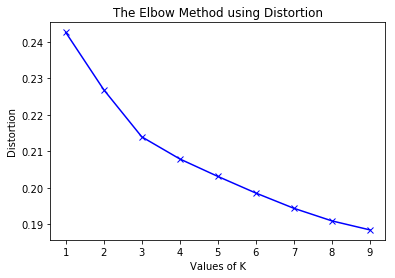

In [34]:
# Elbow method using distortion
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

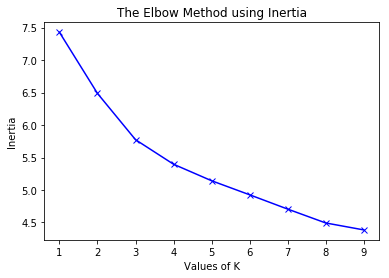

In [35]:
# Elbow method using inertia
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the "elbow" or the point after which the distortion/inertia start decreasing in a linear fashion.

Although somewhat hard to tell, we can estimate that for both distortion and inertia that 3 clusters looks to be the elbow point so the optimal number of clusters for the *sf_grouped_clustering* data is **3**. Now, run the K-means to cluster the neighborhoods into 3 clusters.

In [36]:
# Set number of clusters
kclusters = 3

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [37]:
# Add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sf_merged = neighborhoods_data

# Merge sf_grouped with venues_df to add latitude/longitude for each neighborhood
sf_merged = sf_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sf_merged # check the last columns!

Neighborhood  \
0                        Seacliff   
1                     Lake Street   
2          Presidio National Park   
3                Presidio Terrace   
4                  Inner Richmond   
5                   Sutro Heights   
6        Lincoln Park / Ft. Miley   
7                  Outer Richmond   
8                Golden Gate Park   
9                Presidio Heights   
10   Laurel Heights / Jordan Park   
11                  Lone Mountain   
12                     Anza Vista   
13                     Cow Hollow   
14                   Union Street   
15                       Nob Hill   
16                         Marina   
17                 Telegraph Hill   
18        Downtown / Union Square   
19                     Tenderloin   
20                   Civic Center   
21                   Hayes Valley   
22                   Alamo Square   
23                      Panhandle   
24                 Haight Ashbury   
25                   Lower Haight   
26                      Mint Hill   
27                Duboce Triangle   
28                    Cole Valley   
29                    Rincon Hill   
30                    South Beach   
31                South of Market   
32               Showplace Square   
33                    Mission Bay   
34             Yerba Buena Island   
35                Treasure Island   
36                Mission Dolores   
37                         Castro   
38                   Outer Sunset   
39                       Parkside   
40                     Stonestown   
41                     Parkmerced   
42                      Lakeshore   
43            Golden Gate Heights   
44                    Forest Hill   
45                    West Portal   
46              Clarendon Heights   
47                Midtown Terrace   
48                   Laguna Honda   
49                 Lower Nob Hill   
50                   Upper Market   
51                Dolores Heights   
52                        Mission   
53                   Potrero Hill   
54                       Dogpatch   
55             Central Waterfront   
56                Diamond Heights   
57                 Crocker Amazon   
58                      Fairmount   
59                Peralta Heights   
60                     Holly Park   
61                   Merced Manor   
62                 Balboa Terrace   
63                      Ingleside   
64                 Merced Heights   
65                  Outer Mission   
66             Ingleside Terraces   
67             Mt. Davidson Manor   
68               Monterey Heights   
69             Westwood Highlands   
70                  Westwood Park   
71                  Miraloma Park   
72                   McLaren Park   
73                      Sunnydale   
74              Visitacion Valley   
75                    India Basin   
76            Northern Waterfront   
77                  Hunters Point   
78          Candlestick Point SRA   
79                         Cayuga   
80                      Oceanview   
81                   Apparel City   
82                 Bernal Heights   
83                     Noe Valley   
84                 Produce Market   
85                        Bayview   
86                 Silver Terrace   
87                     Bret Harte   
88               Little Hollywood   
89                      Excelsior   
90                        Portola   
91               University Mound   
92                 St. Marys Park   
93                Mission Terrace   
94                      Sunnyside   
95                      Glen Park   
96               Western Addition   
97       Aquatic Park / Ft. Mason   
98               Fishermans Wharf   
99                 Cathedral Hill   
100                     Japantown   
101               Pacific Heights   
102         Lower Pacific Heights   
103                     Chinatown   
104                    Polk Gulch   
105                   North Beach   
106                  Russian Hill   
107            Financial 

Finally, visualize the resulting clusters.

In [38]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# Generate choropleth map using the total number of commerce venues of each neighborhood
folium.Choropleth(geo_data=f_data,
                  data=sf_grouped_sum,
                  columns=['Neighborhood', 'Total'],
                  key_on='feature.properties.name',
                  fill_color='YlGnBu', 
                  fill_opacity=0.7, 
                  line_opacity=0.2,
                  legend_name='Number of commerce venues',
                  reset=True).add_to(map_clusters)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sf_merged['Latitude'], sf_merged['Longitude'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],
                        radius=5,
                        popup=label,
                        color=rainbow[cluster-1],
                        fill=True,
                        fill_color=rainbow[cluster-1],
                        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 3.6.3 Examine the Clusters

Now, we can examine each cluster to determine the discriminating venue categories that distinguish each cluster. The clusters are:

Cluster | Color      
-----|-----------------
0    |	red   
1    |	purple   
2    |	green  

#### Cluster 0

In [39]:
sf_merged.loc[sf_merged['Cluster Labels'] == 0, sf_merged.columns[[0] + list(range(5, sf_merged.shape[1]))]]

Neighborhood  Cluster Labels  \
0                        Seacliff               0   
1                     Lake Street               0   
3                Presidio Terrace               0   
4                  Inner Richmond               0   
5                   Sutro Heights               0   
6        Lincoln Park / Ft. Miley               0   
7                  Outer Richmond               0   
9                Presidio Heights               0   
10   Laurel Heights / Jordan Park               0   
11                  Lone Mountain               0   
12                     Anza Vista               0   
13                     Cow Hollow               0   
14                   Union Street               0   
15                       Nob Hill               0   
16                         Marina               0   
19                     Tenderloin               0   
20                   Civic Center               0   
21                   Hayes Valley               0   
22                   Alamo Square               0   
23                      Panhandle               0   
24                 Haight Ashbury               0   
25                   Lower Haight               0   
26                      Mint Hill               0   
27                Duboce Triangle               0   
28                    Cole Valley               0   
30                    South Beach               0   
32               Showplace Square               0   
35                Treasure Island               0   
36                Mission Dolores               0   
37                         Castro               0   
38                   Outer Sunset               0   
39                       Parkside               0   
40                     Stonestown               0   
41                     Parkmerced               0   
42                      Lakeshore               0   
45                    West Portal               0   
48                   Laguna Honda               0   
49                 Lower Nob Hill               0   
56                Diamond Heights               0   
57                 Crocker Amazon               0   
59                Peralta Heights               0   
60                     Holly Park               0   
61                   Merced Manor               0   
62                 Balboa Terrace               0   
63                      Ingleside               0   
64                 Merced Heights               0   
65                  Outer Mission               0   
66             Ingleside Terraces               0   
67             Mt. Davidson Manor               0   
68               Monterey Heights               0   
69             Westwood Highlands               0   
70                  Westwood Park               0   
73                      Sunnydale               0   
74              Visitacion Valley               0   
77                  Hunters Point               0   
79                         Cayuga               0   
80                      Oceanview               0   
81                   Apparel City               0   
82                 Bernal Heights               0   
83                     Noe Valley               0   
84                 Produce Market               0   
85                        Bayview               0   
86                 Silver Terrace               0   
87                     Bret Harte               0   
88               Little Hollywood               0   
89                      Excelsior               0   
90                        Portola               0   
91               University Mound               0   
92                 St. Marys Park               0   
93                Mission Terrace               0   
94                      Sunnyside               0   
96               Western Addition               0   
97       Aquatic Park / Ft. Mason               0   
98               Fishermans Wharf               0   
100                     Japantown             

#### Cluster 1

In [40]:
sf_merged.loc[sf_merged['Cluster Labels'] == 1, sf_merged.columns[[0] + list(range(5, sf_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
2     Presidio National Park               1                Office   
17            Telegraph Hill               1                Office   
18   Downtown / Union Square               1                Office   
29               Rincon Hill               1                Office   
31           South of Market               1                Office   
33               Mission Bay               1                Office   
34        Yerba Buena Island               1                Office   
47           Midtown Terrace               1                Office   
50              Upper Market               1                Office   
51           Dolores Heights               1                Office   
52                   Mission               1                Office   
53              Potrero Hill               1                Office   
54                  Dogpatch               1                Office   
55        Central Waterfront               1                Office   
76       Northern Waterfront               1                Office   
78     Candlestick Point SRA               1                Office   
99            Cathedral Hill               1                Office   
107       Financial District               1                Office   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
2                    Park                 Beach   American Restaurant   
17                Parking      Business Service           Fabric Shop   
18         Clothing Store    Salon / Barbershop           Tailor Shop   
29        Harbor / Marina        Clothing Store         Jewelry Store   
31              Nightclub    Mexican Restaurant          Cocktail Bar   
33                   Park            Public Art                  Pier   
34        Harbor / Marina                 Beach         Grocery Store   
47             Hookah Bar          Cocktail Bar           Flower Shop   
50                Parking                  Café          Cocktail Bar   
51                   Café        Cosmetics Shop    Salon / Barbershop   
52           Cocktail Bar    Mexican Restaurant           Pop-Up Shop   
53                   Park           Coffee Shop     Accessories Store   
54             Food Truck     Accessories Store              Creperie   
55     Miscellaneous Shop                  Pier       Automotive Shop   
76                   Pier            Public Art            Food Truck   
78    American Restaurant                  Café           Post Office   
99                    Bar           Flea Market       Thai Restaurant   
107            Shoe Store           Coffee Shop            Food Truck   

    5th Most Common Venue    6th Most Common Venue      7th Most Common Venue  \
2           Women's Store               Food Truck              National Park   
17                   Park          Doctor's Office    Comfort Food Restaurant   
18          Women's Store          Doctor's Office                 Food Truck   
29         Sandwich Place             Burger Joint                   Dive Bar   
31                   Café              Karaoke Bar     Furniture / Home Store   
33            Coffee Shop          Harbor / Marina                 Food Truck   
34                   Park           Hardware Store                       Café   
47   Caribbean Restaurant               Food Truck  Latin American Restaurant   
50            Coffee Shop  New American Restaurant                 Food Truck   
51             Restaurant         Dentist's Office  Latin American Restaurant   
52     Salon / Barbershop       Italian Restaurant                       Food   
53             Food Truck        Convenience Store                    Parking   
54        Bubble Tea Shop           Sandwich Place     Furniture / Home Store   
55         Hardware Store               Food Truck                 Print Shop   
76                  Plaza                  Parking                        Bar   
7

#### Cluster 2

In [41]:
sf_merged.loc[sf_merged['Cluster Labels'] == 2, sf_merged.columns[[0] + list(range(5, sf_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
8       Golden Gate Park               2                  Park   
43   Golden Gate Heights               2                  Park   
44           Forest Hill               2                  Park   
46     Clarendon Heights               2                  Park   
58             Fairmount               2                  Park   
71         Miraloma Park               2                  Park   
72          McLaren Park               2                  Park   
75           India Basin               2                Office   
95             Glen Park               2                  Park   
111          Buena Vista               2                  Park   
112       Corona Heights               2                  Park   
114        Eureka Valley               2                  Park   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
8      Mexican Restaurant       Automotive Shop                Office   
43                 Office     Korean Restaurant                Bakery   
44                 Office                  Food   Japanese Restaurant   
46                 Office    Real Estate Office           Coffee Shop   
58                 Office       Bed & Breakfast           Candy Store   
71            Pizza Place                Office            Food Truck   
72           Liquor Store           Candy Store       Bed & Breakfast   
75                   Park           Post Office            Food Truck   
95          Grocery Store                Office  Cantonese Restaurant   
111                Office               Parking             Nightclub   
112                  Café               Parking          Liquor Store   
114    Italian Restaurant                Office        Cosmetics Shop   

      5th Most Common Venue 6th Most Common Venue  \
8                       Bar    Chinese Restaurant   
43              Frame Store           Men's Store   
44                   Bakery       Doctor's Office   
46           Breakfast Spot            Food Truck   
58               Public Art        Cosmetics Shop   
71                     Food     College Classroom   
72                   Office                Resort   
75           Hardware Store    Salon / Barbershop   
95                   Bakery        Shipping Store   
111                    Food            Steakhouse   
112  Furniture / Home Store          Cocktail Bar   
114         Bed & Breakfast                  Café   

            7th Most Common Venue    8th Most Common Venue  \
8                      Shoe Store          Doctor's Office   
43                           Food          Thai Restaurant   
44                   Burger Joint         Sushi Restaurant   
46                    Tailor Shop     Caribbean Restaurant   
58                    College Lab              Music Store   
71             College Auditorium               Public Art   
72              College Classroom                Nightclub   
75                     Restaurant       Mexican Restaurant   
95                    Coffee Shop        Korean Restaurant   
111                           Bar  State / Provincial Park   
112       State / Provincial Park                Nightclub   
114  General College & University        Convenience Store   

    9th Most Common Venue 10th Most Common Venue  
8      Salon / Barbershop       Dentist's Office  
43        Doctor's Office       Asian Restaurant  
44            Frame Store      French Restaurant  
46     Italian Restaurant      College Classroom  
58               Dive Bar         Breakfast Spot  
71          Grocery Store             Water Park  
72     Mexican Restaurant    Filipino Restaurant  
75             Public Art           Liquor Store  
95     Dim Sum Restaurant            Karaoke Bar  
111        Clothing Store                   Café  
112         Jewelry Store     Real Estate Office  
114          Cocktail Bar          Grocery Store

After examining each cluster:
* Cluster 0 looks to be all the neighborhoods with varying venues as their first and second most common venues.
* Cluster 1 neighborhoods have offices as their most common venues and varying venues as their second most common venues. 
* Cluster 2 neighborhoods have parks as their most common venues and either offices or some kind of edible goods retailer/service as their second most common venues.

## 4. Results & Discussion <a name="item4"></a>

The results of the San Francisco neighborhood analysis will be discussed in this section and a list of recommended neighborhoods will be provided to answer the three location factors and satisfy JB's criterias for her restaurant.

As a recap, the three location factors that will influence the success of a business are: 
1. Whether or not the location is best suited for the business's target market.
2. The location's area traffic.
3. Whether or not the location offers easy accessibilty and visibility.

### 4.1 Satisfying the Three Location Factors

#### 4.1.1 Should Appeal to Everyone

JB's target customers are both locals and tourists. Throughout the analysis, we have been systematically trying to satisfy the first factor in that we were slowly narrowing down the list of neighborhoods that have both locals and tourists. So now, let's finally identify the neighborhoods that have the greatest diversity of commerce venues.

To do this, drop all the lines that have a zero to ensure that at least one of all commerce venues is within the neighborhood.

In [42]:
sf_grouped_sum2 = sf_grouped_sum[(sf_grouped_sum[['Business Offices','Colleges','Hotels','Public Areas','Restaurants','Shopping Areas','Social Places']] !=0).all(axis=1)]
sf_grouped_sum2

Neighborhood  Business Offices  Colleges  Hotels  \
0                    Alamo Square                 2         1       1   
20                     Cow Hollow                 3         1       7   
50   Laurel Heights / Jordan Park                12         1       1   
55                 Lower Nob Hill                12         1       3   
58                   McLaren Park                 1         2       1   
66                Mission Dolores                 3         2       1   
114            Westwood Highlands                 6         2       1   

     Public Areas  Restaurants  Shopping Areas  Social Places  Total  
0               2            4               2              1     13  
20              2            5               5              3     26  
50              1            6               8              2     31  
55              3           11               3              1     34  
58              4            6               2              2     18  
66              2            4               4              1     17  
114             2            9               2              2     24

And here we are. The list of neighborhoods with every type of commerce venue we just generated will help us to fulfill all three location factors. 

The existence of business offices, colleges, and hotels in the neighborhood will guarantee that there are always hungry locals and tourists in the area searching for food while the public areas, restaurants, shopping areas, and social places ensure the neighborhood is a lively area to be in. There will be enough foot and car traffic in those neighborhoods that JB will not have to worry those districts will ever be deserted.

According to the K-means cluster analysis, every neighborhood in the list, except for McLaren Park, are in cluster 0 which means they have a wide variety of venues. However, even though McLaren Park is in cluster 2, it also features offices, college class rooms, nightclubs, and various ethnic restaurants as some of its top ten most common venues. This further reinforces the three location factors. Those neighborhoods have enough venues of different kinds to attract locals and tourists to visit them, thereby increasing the people traffic. Having a sizable population of locals and tourists frequenting the area, would provide higher probabilities for JB's restaurant to be noticed because there is good chance that her restaurant will be seen by passersby (assuming that it won't be established in a dark alleyway).

The caveat to this list, however, is that there are other lively and bustling neighborhoods that could possibly be better for JB's restaurant which are not included. For example, Excelsior is also one of the most ethnically diverse districts in San Francisco. The diversity of people there, in terms of cultures, would likely provide JB with a good pool of hungry and adventurous customers. But, as this analysis simply acts as a jumping point for JB and also satisfies the three location factors, we will conclude with this list and allow JB to decide.

#### 4.1.2 Is Unique and Stands Out

To attract customers, JB wants her restaurant to be unique in the area that it's in. As such, we should suggest to her neighborhoods that <u>do not</u> have either Indian or Italian restaurants within them to maximize JB's restaurant's uniqueness.

First, list all of the neighborhoods with Indian and/or Italian restaurants.

In [43]:
indian_italian_restaurants_df = restaurants_df[restaurants_df['Venue Category'].isin(['Indian Restaurant', 'Italian Restaurant', 'Pizza Place'])]
indian_italian_restaurants_df = indian_italian_restaurants_df.groupby("Neighborhood")['Venue Category'].count().reset_index()
indian_italian_restaurants_df.rename(columns={'Venue Category': 'Indian/Italian Restaurants Count'}, inplace=True)
indian_italian_restaurants_df

Neighborhood  Indian/Italian Restaurants Count
0         Ashbury Heights                                 1
1          Balboa Terrace                                 1
2          Bernal Heights                                 4
3                  Castro                                 3
4          Cathedral Hill                                 1
5                  Cayuga                                 1
6       Clarendon Heights                                 1
7             Cole Valley                                 1
8          Crocker Amazon                                 1
9           Eureka Valley                                 2
10       Fishermans Wharf                                 1
11              Glen Park                                 1
12         Haight Ashbury                                 1
13           Hayes Valley                                 1
14             Holly Park                                 3
15              Ingleside                                 1
16     Ingleside Terraces                                 1
17         Inner Richmond                                 2
18           Inner Sunset                                 6
19           Laguna Honda                                 1
20            Lake Street                                 2
21              Lakeshore                                 3
22           Lower Haight                                 2
23         Lower Nob Hill                                 3
24  Lower Pacific Heights                                 1
25         Merced Heights                                 3
26        Midtown Terrace                                 1
27          Miraloma Park                                 1
28                Mission                                 1
29        Mission Dolores                                 1
30       Monterey Heights                                 2
31     Mt. Davidson Manor                                 2
32               Nob Hill                                 5
33             Noe Valley                                 1
34            North Beach                                 9
35              Oceanview                                 1
36          Outer Mission                                 1
37         Outer Richmond                                 2
38           Outer Sunset                                 2
39        Pacific Heights                                 2
40              Panhandle                                 1
41             Parkmerced                                 1
42               Parkside                                 2
43        Peralta Heights                                 2
44                Portola                                 1
45       Presidio Terrace                                 1
46               Seacliff                                 1
47        Sherwood Forest                                 1
48       Showplace Square                                 1
49         Silver Terrace                                 1
50            South Beach                                 1
51        South of Market                                 1
52       St. Francis Wood                                 3
53         St. Marys Park                                 2
54              Sunnydale                                 2
55              Sunnyside                                 2
56           Union Street                                 1
57            West Portal                                 4
58     Westwood Highlands                                 1
59          Westwood Park                                 1

Then, find all of the neighborhoods with at least one of all commerce venues that are <u>not</u> in the above list.

In [44]:
# Left join indian_italian_restaurants_df on sf_grouped_sum2
all_commerce_neighborhoods = pd.merge(sf_grouped_sum2, indian_italian_restaurants_df, on='Neighborhood', how='left')

# Keep all rows that have NaN in the newly merged data
all_commerce_neighborhoods = all_commerce_neighborhoods[all_commerce_neighborhoods['Indian/Italian Restaurants Count'].isna()]

# Delete the column of NaN's
del all_commerce_neighborhoods['Indian/Italian Restaurants Count']

all_commerce_neighborhoods

Neighborhood  Business Offices  Colleges  Hotels  \
0                  Alamo Square                 2         1       1   
1                    Cow Hollow                 3         1       7   
2  Laurel Heights / Jordan Park                12         1       1   
4                  McLaren Park                 1         2       1   

   Public Areas  Restaurants  Shopping Areas  Social Places  Total  
0             2            4               2              1     13  
1             2            5               5              3     26  
2             1            6               8              2     31  
4             4            6               2              2     18

Now, we see all of the previously recommended neighborhoods that do not have either an Indian or Italian restaurant. This list of four neighborhoods will be great for JB to start exploring because they are bustling neighborhoods (as described in section *4.1.1*) and the lack of Indian and Italian restaurants will maximize JB's restaurant's uniqueness in the area.

#### 4.1.3 Will Primarily Serve Lunch and Dinner

Although our data does not have information that can explicitly answer this criteria, we can deduce from the list of recommended neighborhoods in section *4.1.2* that those neighborhoods are busy throughout the day. This is because all of the commerce venues are obviously openned at least during mornings and afternoons. There would be employees from the business offices that would want to order lunch on weekdays while the students from the colleges and anyone else who are living, shopping, or socializing in the area will no doubt be searching for food throughout the day, on any day.

#### 4.1.4 Will Be Moderately Priced

Once again, our data does not have any information that can directly address this fourth criteria but we can make educated assumptions that people who live in, work in, and/or frequent the recommended neighborhoods will most likely have enough money to eat at JB's restaurant. For example, according to *Wikipedia*, the demographics of Alamo Square include many young people and upper-middle-class homeowners, Laurel Heights is an upper-middle-class suburban neighborhood, and Cow Hollow is a generally affluent neighborhood. Therefore, it wouldn't be unusual for JB to open a moderately priced restaurant in the list of recommended neighborhoods.

## 5. Conclusion <a name="item5"></a>

The purpose of this project was to identify several neighborhoods in San Francisco for JB to start exploring for her Indian-Italian fusion cuisine restaurant. Only the three location factors as described in the *Background* section of this notebook were used to determine the list of recommended neighborhoods. In the analysis, we systematically checked off each of JB's criterias while also satisfying the three location factors. For example, we found the locations of every Indian and Italian restaurant in San Francisco to search for neighborhoods that can maximize JB's restaurant's uniqueness. Each commerce venue was grouped into the larger commerce venue categories of: Business Offices, Colleges, Hotels, Public Areas, Restaurants, Shopping Areas, and Social Places. This subdivision allowed us to analyze what commerce types each neighborhood is generally known for. Finally, we narrowed the list of neighborhoods to the four most promising ones for JB which include Alamo Square, Cow Hollow, Laurel Heights, and McLaren Park. Although these four neighborhoods are the recommended ones, it should be noted that there are other neighborhoods that may just be as fitting for JB to look into. Ultimately, this analysis will act as a starting point for JB and it will be up to her to make the final decision.

## Bibliography

DataSF. (2019). *SF Find Neighborhoods*. [Data set].
    https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4

Foursquare. (2019). [Data set]. https://foursquare.com/

Gupta, Alind. (2019, June 6). *Elbow Method for optimal value of k in KMeans*. GeeksforGeeks.
    https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

*Why the Locations of Your Restaurant is So Important*. TigerChef.
    https://www.tigerchef.com/why-the-location-of-your-business-is.html